# The Code
For loading data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook


def rainbow(n, i, shift=0):
    if n == 1: return plt.cm.nipy_spectral(0)
    x = i / (n-1) + shift
    return plt.cm.nipy_spectral(0.96 * (x % 1.01))


METALEN = 6
INIT_SAMPLE = 200
CLIPPING_WARNING = 15


def load_u1drive1(inputfile, metalen=6):
    data = pd.read_csv(inputfile, delimiter='\t', header=None).values
    assert np.all(np.absolute(data[:, metalen:] < CLIPPING_WARNING)), "Clipping values in "+fname
    return data

# Load data from running u1drive1 on a chain of Red Pitayas
# with the result being mixed into one file.
def load_chain(inputfile):
    data = pd.read_csv(inputfile, delimiter='\t', header=None).values
    assert np.all(data[:,0] == data[0,0]), "Not all at same samplerate in "+inputfile
    assert np.all(np.absolute(data[:, METALEN:]) < CLIPPING_WARNING), "Maybe clipping values in "+inputfile
    chnum = int(np.max(data[:,5]))
    shots = data.shape[0] // chnum
    
    # Splice rows to order data
    # (all rows of the same shot next to each other)
    # 1, 2, 1, 2, ..., 3, 4, 3, 4, ...  =>  1, 2, 3, 4, 1, 2, 3, 4, ....
    sorted = np.zeros(data.shape)
    for i in range(shots):
        for rpidx in range(chnum//2):
            sorted[chnum*i+rpidx*2]   = data[shots*rpidx*2+i*2]
            sorted[chnum*i+rpidx*2+1] = data[shots*rpidx*2+i*2+1]

    return sorted, chnum, shots

# Since the full chain is longer than we have channels, need to combine.
# datas: list of data DataFrames as returned by load_chain.
# idxs: list of 2-tuples with idx in datas and one channel idx (starting from 0)
def mux_chain(datas, idxs):
    n = len(idxs)
    chnums = [int(np.max(d[:,5])) for d in datas]
    
    recordnum = datas[0].shape[0] // chnums[0]
    assert all(d.shape[0]//chn == recordnum for d, chn in zip(datas, chnums)),\
        "Number of measurements doesn't match for all data sets."
    
    chain = np.empty((len(idxs)*recordnum, datas[0].shape[1]), dtype=datas[0].dtype)
    for i, (dataidx, chidx) in enumerate(idxs):
        data, chn = datas[dataidx], chnums[dataidx]
        chain[i::n] = data[chidx::chn]
        chain[i::n,5] = i+1 # reset channel number (starting from 1)
    return chain

For calculating detuning from site frequencies:

In [3]:
def calc_δs(fs):
    fsites = fs[::2]
    flinks = fs[1::2]
    return np.array([
        flinks[i] - (-1)**(i+1) * (fsites[i] - fsites[i+1]) for i in range(len(flinks))])

For plotting spectra:

In [4]:
from numpy.fft import rfft, rfftfreq
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator


def spectral_density(signal, samplerate):
    fft = np.absolute(rfft(signal * np.hamming(signal.shape[-1]), axis=-1) / samplerate)
    fftbins = rfftfreq(signal.shape[-1], 1/samplerate)
    return fft, fftbins


def plot_traces(data, idx=0):
    print("samplerate {}, frequency {} Hz,\namplitude {} V, phase {} rad,\nch2 delay {} s".format(*data[idx*2,:METALEN-1]))
    samplerate = data[idx*2, 0]
    ts = (np.arange(data.shape[1]-METALEN)-INIT_SAMPLE) / samplerate

    chnum = int(np.max(data[:,5]))
    fig, axs = plt.subplots(nrows=chnum, figsize=(10,13), sharex=True)
    for ch in range(chnum):
        axs[ch].plot(ts*1e3, data[idx*chnum+ch, METALEN:])
        axs[ch].set_ylabel(f"CH{ch+1}")
        axs[ch].grid()
    axs[-1].set_xlabel('time / ms')
    fig.tight_layout()


def plot_spectrum(data, fs, frange=10e3, vmin=1e-7, vmax=1e-2, cmap='viridis'):
    # Need all samplerates to be the same
    assert np.allclose(data[:,0], data[0,0])
    samplerate = data[0,0]
    chnum = int(np.max(data[:,5]))
    
    ffts, fftbins = spectral_density(data[:,6+INIT_SAMPLE:], samplerate)
    
    fig, axs = plt.subplots(ncols=chnum, figsize=(12, 5), sharex=True, constrained_layout=True)
    for i, f in zip(range(chnum), fs):
        im = axs[i].pcolormesh(
            data[i::chnum,1]/1e3, fftbins/1e3, ffts[i::chnum].T,
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap, shading='auto')
        axs[i].set_ylim((f-frange)/1e3, (f+frange)/1e3)
        axs[i].set_xlabel("f drv / kHz")
        axs[i].set_title(f"CH{i+1}")
    axs[0].set_ylabel("f signal / kHz")
    fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz')
    plt.savefig('/home/hannes/plot.png')


def plot_spectrum_full(datas, fs, idxs, frange=10e3, vmin=1e-6, vmax=3e-3):
    fdata = [spectral_density(data[:,6:], data[0,0]) for data in datas]
    fig, axs = plt.subplots(ncols=len(fs), figsize=(9, 3.5), sharex=True, constrained_layout=True)
    for i, f in enumerate(fs):
        dataidx, chidx = idxs[i]
        ffts, fftbins = fdata[dataidx]
        chnum = int(np.max(datas[dataidx][:,5]))
        cmap = 'Purples' if i%2 == 0 else 'Oranges'
        im = axs[i].pcolormesh(
            datas[dataidx][chidx::chnum,1]/1e3, fftbins/1e3, ffts[chidx::chnum].T,
            norm=LogNorm(vmin=vmin, vmax=vmax),
            cmap=cmap, shading='auto')
        axs[i].set_ylim((f-frange)/1e3, (f+frange)/1e3)
        axs[i].set_xlabel("f drv / kHz")
        axs[i].set_title(f"$V_{i//2+1}" + ("'" if i%2==1 else "") + "$")
        axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_ylabel("f signal / kHz")
    fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz')
    plt.savefig('/home/hannes/plot.png', dpi=600)

Envelope extraction and conserved quantities:

In [5]:
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import InterpolatedUnivariateSpline as Spline1D


def slice_compose(*slices):
    assert all(s.stop >= 0 for s in slices)
    return slice(
        sum(s.start for s in slices),
        slices[-1].stop + sum(s.start for s in slices[:-1]))

def slice_intersect(slices, data=None):
    """Calculate intersection of slices.
    Optionally return data inside intersection (first axis) of every slice."""
    # Assertion not necessary. Might be interesting to use in cases
    # where this assertion is not true ;)
    # assert all(s.step is None or s.step == 1 for s in slices)
    
    inters = slice(
        max(s.start for s in slices),
        min(s.stop for s in slices))
    assert inters.start <= inters.stop, "No intersection."
    
    if data:
        interd = [
            trace[inters.start-s.start:inters.stop-s.start,...]
            for s, trace in zip(slices, data)
        ]
        return inters, interd
    else:
        return inters


def envelope_spline(signal, samplerate, fexp,
                    start_thresh=0.2, peak_height=0.02, quiet=False):
    """Optionally smooth signal, get peaks, optionally smooth peaks, make spline for envelope.
    
    Returns: tuple of
      time for each sample in seconds, 0s at trigger,
      spline object based on time in seconds,
      slice for time where spline is valid,
      rms error of envelope smoothing.
    """
    ts = (np.arange(signal.shape[0]) - INIT_SAMPLE) / samplerate
    
    # First smoothing: signal
    beginidx = np.argmax(signal > start_thresh)
    smoothwin = int(samplerate/fexp / 10)
    smoothwin -= 1 if smoothwin % 2 == 0 else 0
    if smoothwin > 3:
        if not quiet: print(f"  Signal: smoothing window: {smoothwin} samples")
        smoothed = savgol_filter(signal[beginidx:], window_length=smoothwin, polyorder=3)
    else:
        if not quiet: print(f"  Signal: no smoothing, window {smoothwin} samples !> 3")
        smoothed = signal[beginidx:]
    
    # Find peaks and fit spline (envelope).
    # Note that indexing for these arrays is offset by `beginidx`.
    peakidxs = find_peaks(smoothed, height=peak_height, distance=0.75*samplerate/fexp)[0]
    
    favg = (peakidxs.size-1) / (ts[beginidx+peakidxs[-1]] - ts[beginidx+peakidxs[0]])
    t_jitter = np.std(np.diff(ts[beginidx+peakidxs]))
    V_jitter = np.sqrt(np.mean((np.diff(smoothed[peakidxs]))**2))
    if not quiet:
        print(f"  Avg peak frequency: {favg/1e3:.3f} kHz")
        print(f"  Jitter of peak positions: {t_jitter*1e6:.5f} us ({1e-6/t_jitter:.2f} MHz)")
        print(f"  Jitter of peak heights:   {V_jitter:.4f} V")
    
    spline = Spline1D(ts[beginidx:][peakidxs], signal[beginidx:][peakidxs], k=3)
    srange = slice(beginidx+peakidxs[0], beginidx+peakidxs[-1])
    
    return ts, spline, srange, V_jitter


def envelope_properties(ts, env, fbeatexp):
    samplerate = (ts.size-1) / (ts[-1] - ts[0])
    peaks = find_peaks(env, distance=0.8*samplerate/fbeatexp)[0]
    # Omit outmost peaks which might not be peaks
    peaks = peaks[1:-1]
    
    if len(peaks) < 2:
        return np.array([]), np.nan, np.nan, np.nan, np.nan, np.nan
    
    tjitter = np.std(np.diff(ts[peaks])) / np.sqrt(2)
    print(f"Beat: peak jitter: {tjitter*1e3:f} ms")
    
    # Frequency
    favg = (peaks.size - 1) / (ts[peaks[-1]] - ts[peaks[0]])
    if favgerr is None:
        favgerr = (peaks.size - 1) / (ts[peaks[-1]] - ts[peaks[0]])**2 * np.sqrt(2) * tjitter
    print(f"Beat: Avg peak frequency: {favg/1e3:f} ± {favgerr/1e3:f} kHz")
    
    return peaks, favg, favgerr


def topbot(ts, signal, fbeat):
    """Use peaks to get top and bottom range of signal, interpolated linearly between peaks."""
    samplerate = 1 / (ts[1] - ts[0])
    peakidxs = find_peaks(signal, distance=0.75*samplerate/fbeat)[0]
    troughidxs = find_peaks(-signal, distance=0.75*samplerate/fbeat)[0]
    srange = slice(max(np.min(peakidxs), np.min(troughidxs)), min(np.max(peakidxs), np.max(troughidxs)))
    top = np.interp(ts[srange], ts[peakidxs], signal[peakidxs])
    bot = np.interp(ts[srange], ts[troughidxs], signal[troughidxs])
    return srange, top, bot


def energy(V, Verr, C=20e-9):
    """Energy stored in capacitor at given Voltage.  Returns E, Eerr."""
    return (
        C/2 * V**2,
        C * V * Verr
    )


# Assumes site 1, link 1, site 2, link 2, ... along first axis
def Gx(Es, Eerr, fs, f0=60e3):
    Eerr = np.broadcast_to(Eerr, Es.shape)
    l = (Es.shape[0]+1)//2
    Gs, Gerr = [], []
    Gtot, Gtoterr2 = 0, 0
    for i in range(l):
        x = i + 1 # x starting from 1
        
        G = Es[2*i] * f0/fs[2*i]
        Gerr2 = (Eerr[2*i] * f0/fs[2*i])**2
        if 2*i > 0:
            G += (-1)**x * Es[2*i-1] * f0/fs[2*i-1]
            Gerr2 += (Eerr[2*i-1] * f0/fs[2*i-1])**2
        if 2*i < Es.shape[0]-1:
            G += (-1)**x * Es[2*i+1] * f0/fs[2*i+1]
            Gerr2 += (Eerr[2*i+1] * f0/fs[2*i+1])**2
        Gs.append(G), Gerr.append(np.sqrt(Gerr2))
        
        Gtot += Es[2*i] * f0/fs[2*i]
        Gtoterr2 += (Eerr[2*i] * f0/fs[2*i])**2

    return np.array(Gs), np.array(Gerr), Gtot, np.sqrt(Gtoterr2)


# Like G but averages over contributions for G instead of calculating G.
# Assumes site 1, link 1, site 2, link 2, ... along first axis
def GΔavg(Es, Eerr, fs, f0=60e3):
    Eerr = np.broadcast_to(Eerr, Es.shape)
    l = (Es.shape[0]+1)//2
    Gs, Gerr = [], []
    Gtot, Gtoterr2 = 0, 0
    for i in range(l):
        x = i + 1 # x starting from 1
        
        N = 1
        G = Es[2*i] * f0/fs[2*i]
        Gerr2 = (Eerr[2*i] * f0/fs[2*i])**2
        if 2*i > 0:
            G += Es[2*i-1] * f0/fs[2*i-1]
            Gerr2 += (Eerr[2*i-1] * f0/fs[2*i-1])**2
            N += 1
        if 2*i < Es.shape[0]-1:
            G += Es[2*i+1] * f0/fs[2*i+1]
            Gerr2 += (Eerr[2*i+1] * f0/fs[2*i+1])**2
            N += 1
        Gs.append(G/N), Gerr.append(np.sqrt(Gerr2/N))
        
        Gtot += Es[2*i] * f0/fs[2*i]
        Gtoterr2 += (Eerr[2*i] * f0/fs[2*i])**2

    return np.array(Gs), np.array(Gerr), Gtot, np.sqrt(Gtoterr2)

For current measurements:

In [6]:
def demodulate(signal, f, samplerate):
    # cut to multiple of cycles
    ncycles = np.floor(len(signal) / (samplerate/f))
    nsamples = int(ncycles * (samplerate/f))
    dat = signal[:nsamples]
    # remove mean
    dat = dat - np.mean(dat)
    # reference oscillator
    refc = np.cos(np.arange(len(dat)) * 2*np.pi * f/samplerate)
    refs = np.sin(np.arange(len(dat)) * 2*np.pi * f/samplerate)

    I = np.trapz(dat * refc)
    Q = np.trapz(dat * refs)
    A = np.sqrt(I**2 + Q**2) * 2 / len(dat)
    φ = np.arctan2(-Q, I)

    return ncycles, A, φ


# Assumes CH1: Vcircuit, CH2: Vsense
def measure_current(data, Rsense=33):
    chnum = int(np.max(data[:,5]))
    Vcircuit, Vsense = data[0::chnum,6:], data[1::chnum,6:]
    I = (Vcircuit - Vsense) / Rsense
    Idemod = pd.DataFrame(
        [demodulate(I[i], data[::chnum,1][i], data[::chnum,0][i])
            for i in range(I.shape[0])],
        columns=['ncyc', 'amp', 'phi'])
    Irms = np.sqrt(np.mean(I**2, axis=1))
    return I, Idemod, Irms

# 11-24 Set 3
## Spectrum (figure 33a)

<IPython.core.display.Javascript object>


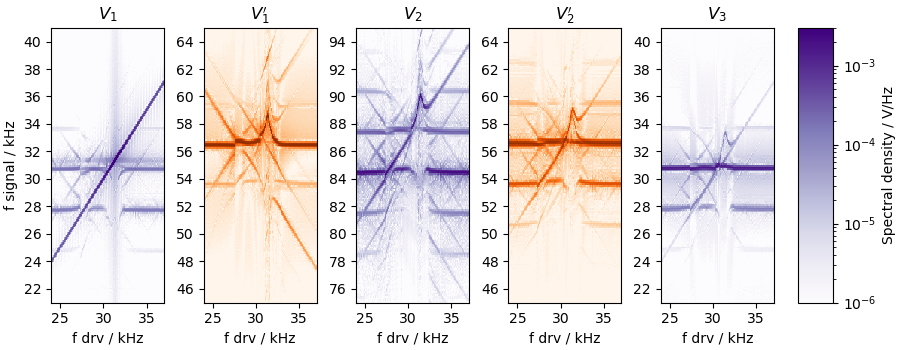

In [12]:
data1, _, _ = load_chain('data_three-sites/11-24 set3 CH1:V1_CH2:V2_CH3:V3_CH4:V2link_Vdrv=0.05V.gz')
data2, _, _ = load_chain('data_three-sites/11-24 set3 CH1:V1_CH2:V2_CH3:V1link_CH4:V2link_Vdrv=0.05V.gz')
plot_spectrum_full([data1, data2], [31e3, 55e3, 85e3, 55e3, 31e3], [(0, 0), (1, 3-1), (0, 2-1), (0, 4-1), (0, 3-1)], frange=10e3)

## Conservation (figure 34)

<IPython.core.display.Javascript object>


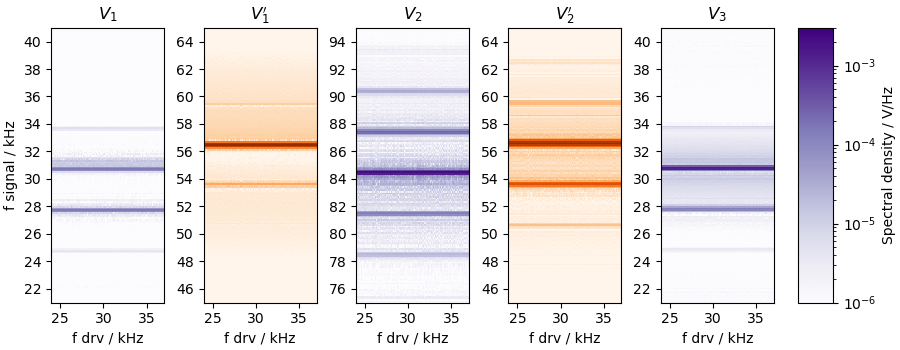

In [13]:
data1, _, _ = load_chain('data_three-sites/11-24 set3 CH1:V1_CH2:V2_CH3:V3_CH4:V2link_Vdrv=0.gz')
data2, _, _ = load_chain('data_three-sites/11-24 set3 CH1:V1_CH2:V2_CH3:V1link_CH4:V2link_Vdrv=0.gz')
plot_spectrum_full([data1, data2], [31e3, 55e3, 85e3, 55e3, 31e3], [(0, 0), (1, 3-1), (0, 2-1), (0, 4-1), (0, 3-1)], frange=10e3)

δs: [3.98 3.02] kHz


<IPython.core.display.Javascript object>


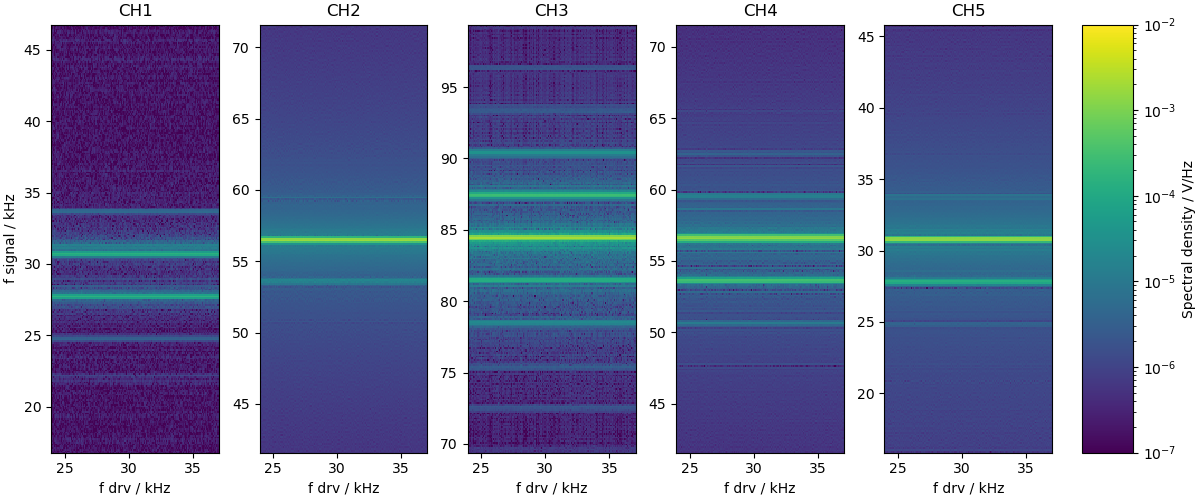

In [14]:
fs = [31.78e3, 56.59e3, 84.39e3, 56.57e3, 30.84e3]
print('δs:', calc_δs(fs)/1e3, 'kHz')


chain = mux_chain([data1, data2], [(0, 0), (1, 3-1), (0, 2-1), (0, 4-1), (0, 3-1)])
plot_spectrum(chain, fs, frange=15e3)

(750, 16390)
150
[1.9531250e+06 2.6268457e+04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00]
samplerate 1953125.0, frequency 28536.912108999997 Hz,
amplitude 0.0 V, phase 0.0 rad,
ch2 delay 0.0 s


<IPython.core.display.Javascript object>


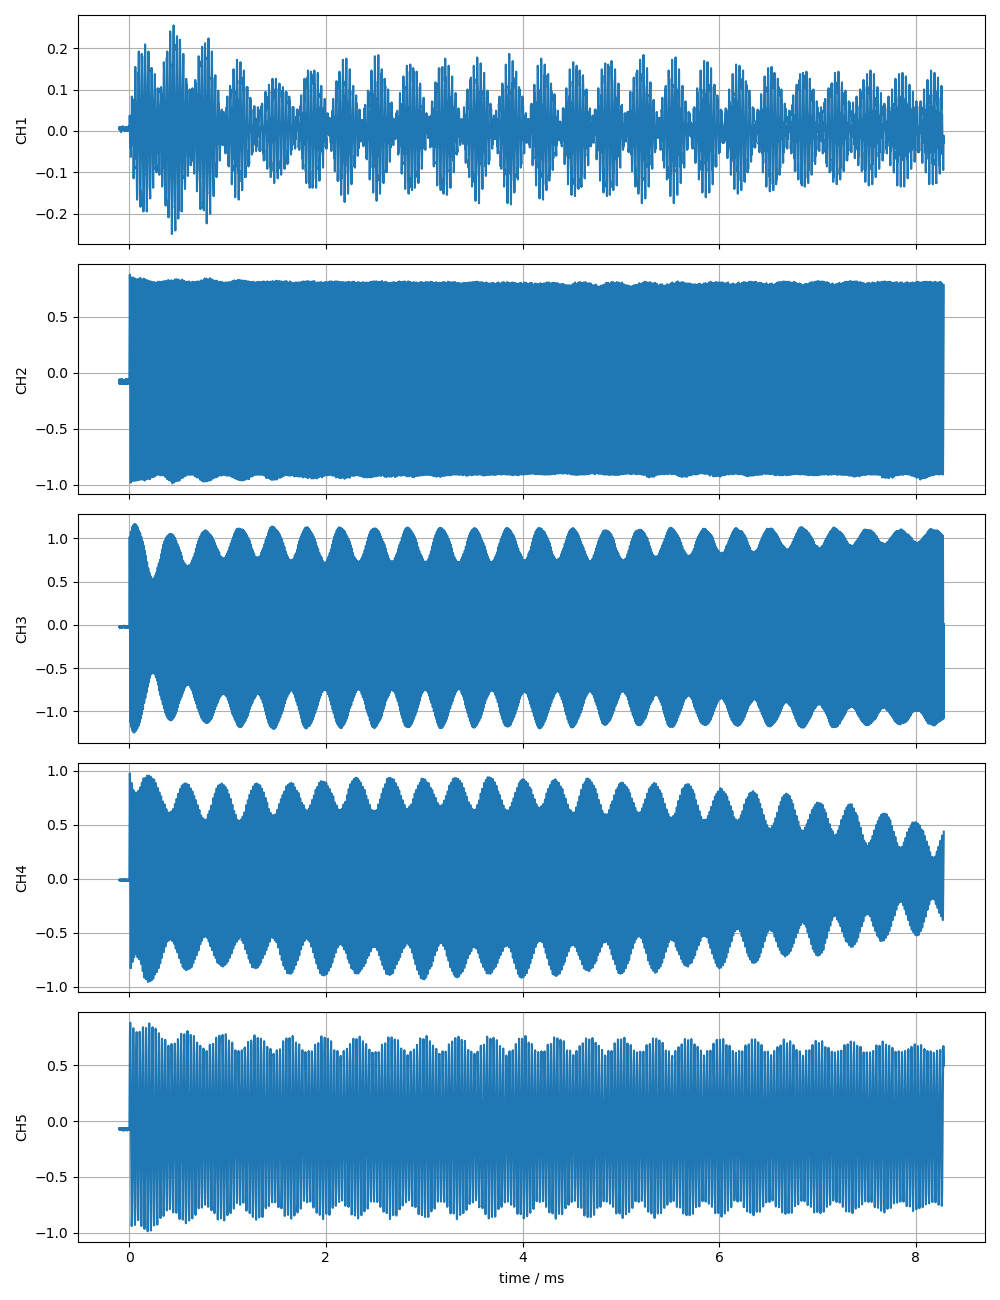

In [15]:
print(chain.shape)
print(chain.shape[0]//5)

idx = 130 # !!!
print(chain[idx,:6])

plot_traces(chain, idx)

In [16]:
fbeat = 3e3 # !!!
rangeprefactor = 0.9

f0 = 80e3
l, n = (len(fs)+1)//2, len(fs)

# Envelopes
samplerate = chain[idx,0]
ts, splines, sranges, Vjitters = None, [], [], []
for j in range(n):
    print(f"CH{j+1}")
    ts, spline, srange, Vjitter = envelope_spline(chain[idx*n+j,6:], samplerate, fs[j])
    splines.append(spline), sranges.append(srange), Vjitters.append(Vjitter)
Vjitters = np.array(Vjitters)
srange = slice_intersect(sranges)

# Energies and 'charges' alingned to slice intersection
Vs = np.array([spline(ts[srange]) for spline in splines])
Es, Eerr = energy(Vs, Vjitters[:,np.newaxis])
Gs, Gerr, Gtot, Gtoterr = Gx(Es, Eerr, fs, f0)

# Ranges
Ers, Etop, Ebot = [], [], []
for j in range(n):
    E, _ = energy(splines[j](ts[sranges[j]]), Vjitters[j])
    r, top, bot = topbot(ts[sranges[j]], E, rangeprefactor*fbeat)
    Ers.append(r), Etop.append(top), Ebot.append(bot)
ΔE = [Etop[j] - Ebot[j] for j in range(n)]

Grs, Gtop, Gbot = [], [], []
for j in range(l):
    r, top, bot = topbot(ts[srange], Gs[j], rangeprefactor*fbeat)
    Grs.append(r), Gtop.append(top), Gbot.append(bot)
ΔG = [Gtop[i] - Gbot[i] for i in range(l)]

# unify ranges
rangeF, ΔEG = slice_intersect(
    [slice_compose(sranges[j], Ers[j]) for j in range(n)] + [slice_compose(srange, Grs[i]) for i in range(l)],
    ΔE + ΔG) # <- list concatenation, not adding elements
ΔE, ΔG = np.array(ΔEG[:len(ΔE)]), np.array(ΔEG[len(ΔE):])
# errors for ranges
reslice = slice(rangeF.start-srange.start, rangeF.stop-srange.start)
ΔEerr = 2**0.5 * Eerr[:,reslice]
ΔGerr = 2**0.5 * Gerr[:,reslice]

# Violation
GΔ, GΔerr, GtotΔ, GtotΔerr = GΔavg(ΔE, ΔEerr, fs, f0)
F = ΔG / GΔ
Ferr = F * np.sqrt((ΔGerr/ΔG)**2 + (GΔerr/GΔ)**2)
print(F.shape)

CH1
  Signal: smoothing window: 5 samples
  Avg peak frequency: 29.376 kHz
  Jitter of peak positions: 4.27024 us (0.23 MHz)
  Jitter of peak heights:   0.0283 V
CH2
  Signal: no smoothing, window 3 samples !> 3
  Avg peak frequency: 56.512 kHz
  Jitter of peak positions: 0.32400 us (3.09 MHz)
  Jitter of peak heights:   0.0072 V
CH3
  Signal: no smoothing, window 1 samples !> 3
  Avg peak frequency: 84.493 kHz
  Jitter of peak positions: 0.18332 us (5.45 MHz)
  Jitter of peak heights:   0.0278 V
CH4
  Signal: no smoothing, window 3 samples !> 3
  Avg peak frequency: 56.637 kHz
  Jitter of peak positions: 0.38954 us (2.57 MHz)
  Jitter of peak heights:   0.0357 V
CH5
  Signal: smoothing window: 5 samples
  Avg peak frequency: 30.825 kHz
  Jitter of peak positions: 0.80016 us (1.25 MHz)
  Jitter of peak heights:   0.0343 V
(3, 14682)


Here follows figure 34 from the thesis:

> Violation of Gauss’s law in measurement set (2) without driving, i. e. Idrv=0. Top: energy of oscillators; middle: charges of Gauss’s law with shaded regions indicating ∆Gx ; bottom two: violation F x with shaded regions showing the scatter due to uncertainties in the voltage measurement. F x = 0 means perfect conservation and values larger one indicate strong violation.

<IPython.core.display.Javascript object>


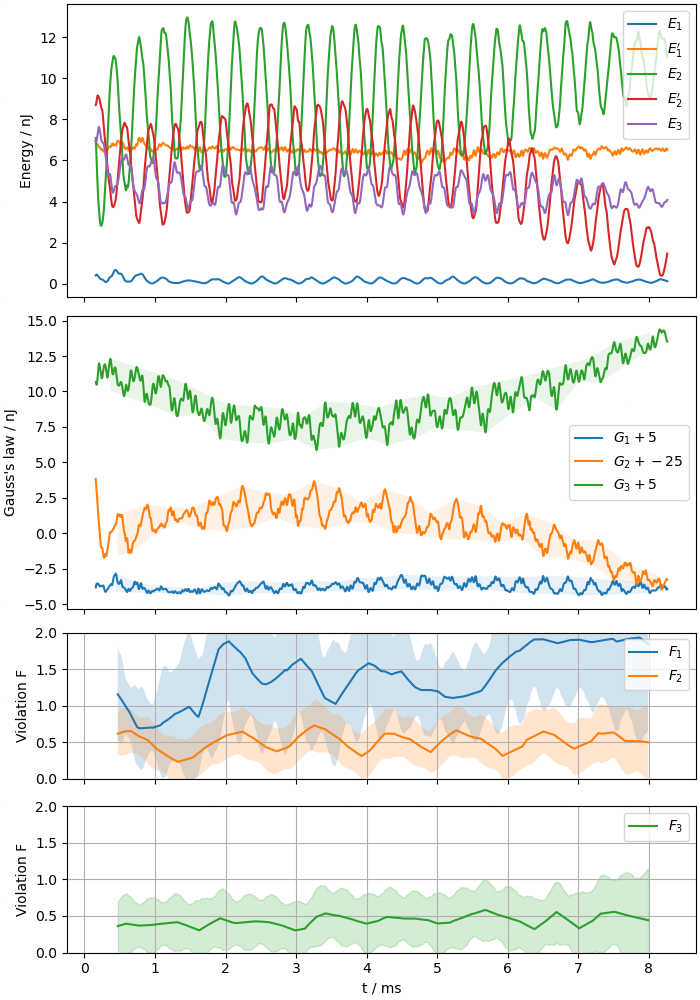

In [17]:
fig, axs = plt.subplots(nrows=4, figsize=(7,10), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [2, 2, 1, 1]})
for i, (E, err, r, top, bot) in enumerate(zip(Es, Eerr, Ers, Etop, Ebot)):
    axs[0].plot(ts[srange]*1e3, E*1e9, label=f"$E_{i//2+1}" + ("'" if i%2==1 else "") + "$")
    #axs[0].fill_between(ts[sranges[i]][r]*1e3, bot*1e9, top*1e9, alpha=0.1)
axs[0].set_ylabel('Energy / nJ')
axs[0].legend(loc='upper right')

for i, shift in zip(range(l), [+5, -25, +5]):
    axs[1].plot(ts[srange]*1e3, Gs[i]*1e9+shift, label=f"$G_{i+1}+{shift}$")
    axs[1].fill_between(ts[srange][Grs[i]]*1e3, Gbot[i]*1e9+shift, Gtop[i]*1e9+shift, alpha=0.1)
#axs[1].plot(ts[srange]*1e3, Gtot*1e9-10, '--', label='$G_\\mathrm{tot}$')
#axs[1].plot(ts[srange]*1e3, np.sum(Es, axis=0)*1e9-21, '--', label='$E_\\mathrm{tot}$')
axs[1].legend()
axs[1].set_ylabel("Gauss's law / nJ")

for i in range(2):
    axs[2].plot(ts[rangeF]*1e3, F[i], label=f"$F_{i+1}$")
    axs[2].fill_between(ts[rangeF]*1e3, F[i]-Ferr[i], F[i]+Ferr[i], alpha=0.2)
axs[2].grid()
axs[2].set_ylim(0, 2)
axs[2].set_ylabel("Violation F")
axs[2].legend(loc='upper right')
    
i = 2
axs[3].plot(ts[rangeF]*1e3, F[i], color='C2', label=f"$F_{i+1}$")
axs[3].fill_between(ts[rangeF]*1e3, F[i]-Ferr[i], F[i]+Ferr[i], alpha=0.2, color='C2')
axs[3].grid()
axs[3].set_ylim(0, 2)
axs[3].set_ylabel("Violation F")
axs[3].legend(loc='upper right')
axs[3].set_xlabel("t / ms")
plt.savefig('/home/hannes/plot.pdf')

# 11-23 Set 2 (figure 32a)

In [20]:
data1, _, _ = load_chain('data_three-sites/11-23 set2 CH1:V1_CH2:Rsense_CH3:V2_CH4:V3_Vdrv=0.05V.gz')
data2, _, _ = load_chain('data_three-sites/11-23 set2 CH1:V1_CH2:Rsense_CH3:V1link_CH4:V2link_Vdrv=0.05V.gz')

<IPython.core.display.Javascript object>


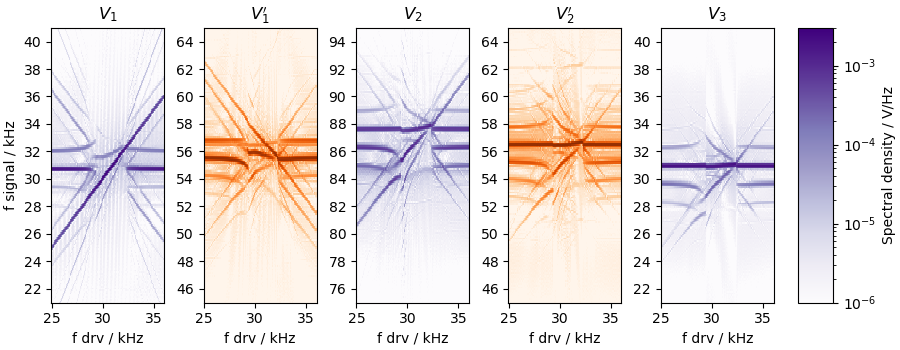

In [21]:
plot_spectrum_full([data1, data2], [31e3, 55e3, 85e3, 55e3, 31e3], [(0, 0), (1, 3-1), (0, 3-1), (1, 4-1), (0, 4-1)])